In [51]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import geopandas as gpd

test_df = pd.read_excel("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/data/external/Solar PV installations west midlands.xlsx", sheet_name="Sheet3")
test_df['Postcode'] = test_df['Postcode'].str.upper()
test_df = test_df[test_df['Postcode'].isna()==False]

test_add_cols = ['Address Line 1', 'Address Line 2', 'Address Line 3']
test_df[test_add_cols] = test_df[test_add_cols].fillna('')
test_df['full_address'] = test_df[test_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

results_df = pd.read_csv("output/SJ9000_results.csv")
results_df['buildingNumber'] = results_df['buildingNumber'].astype('Int64').astype(str)
results_df['buildingNumber'] = results_df['buildingNumber'].str.replace("<NA>", "")
results_df['postcode'] = results_df['postcode'].str.replace(r"/s", "")

results_add_cols = ['buildingNumber', 'thoroughfare']
results_df[results_add_cols] = results_df[results_add_cols].fillna('')
results_df['full_address'] = results_df[results_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
results_df = results_df[results_df['full_address'] !='']

C:\Users\lilia\AppData\Local\Temp\ipykernel_19756\2991163045.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  results_df['postcode'] = results_df['postcode'].str.replace(r"\s", "")


In [52]:
unq_postcode = list(results_df.postcode.unique())

uprn = {}
mapped_add = {}
score = {}
for postcode, grp in test_df.groupby('Postcode'): 
    if postcode in unq_postcode:
        sub_results = results_df[results_df.postcode==postcode]
        for i in grp.index:
            if sub_results['full_address'].shape[0]:
                fuzz_score = [fuzz.partial_ratio(grp['full_address'][i], add) for add in sub_results['full_address']]
                idx = sub_results.index[np.argmax(np.array(fuzz_score))]
                if max(fuzz_score) > 80:
                    uprn[i] = sub_results['uprn'][idx]
                    mapped_add[i] = sub_results['full_address'][idx]
                    score[i] = max(fuzz_score)

In [53]:
matched_uprn = test_df.loc[uprn.keys()]
matched_uprn['uprn'] = uprn.values()
matched_uprn['mapped_address'] = mapped_add.values()
matched_uprn['score'] = score.values()

In [55]:
matched_uprn[matched_uprn.score<=95]

,Address Line 1,Address Line 2,Address Line 3,County,Postcode,Meter Reading,Total Installed Capacity,Estimated Annual Generation,Products,Technology Type,Overall Cost,full_address,uprn,mapped_address,score
58998,11,LESLIE ROAD,WOLVERHAMPTON,NaN,WV100BT,10,6.80,5161.0,(ID: 34385 | MCS Product Number: K2 SolidRail ...,Solar Photovoltaic,1001.0,11 LESLIE ROAD WOLVERHAMPTON,100071172204,115 LESLIE ROAD,93
13366,39,LAWRENCE AVENUE,WOLVERHAMPTON,NaN,WV100QJ,0,2.50,2342.0,(ID: 19074 | MCS Product Number: RSM-60-6-250P...,Solar Photovoltaic,0.0,39 LAWRENCE AVENUE WOLVERHAMPTON,100071171145,19 LAWRENCE AVENUE,94
9707,17,,OVAL DRIVE,NaN,WV106AX,0.5,3.92,3461.0,(ID: 12734 | MCS Product Number: ND-R235A6 | P...,Solar Photovoltaic,7285.0,17 OVAL DRIVE,10090014039,1 OVAL DRIVE,92
58086,60,COMET DRIVE,WOLVERHAMPTON,West Midlands,WV109AZ,0.52,2.20,1845.0,(ID: 34385 | MCS Product Number: K2 SolidRail ...,Solar Photovoltaic,2700.0,60 COMET DRIVE WOLVERHAMPTON,10093327057,40 COMET DRIVE,93
6309,144A,SPRINGHILL ROAD,,NaN,WV113AQ,0,NaN,2796.0,(ID: 5948 | MCS Product Number: TSM-xxxDC01.10...,Solar Photovoltaic,0.0,144A SPRINGHILL ROAD,100071194992,114 SPRINGHILL ROAD,89
15312,91,SPRINGHILL ROAD,WOLVERHAMPTON,NaN,WV113AQ,0,3.25,2930.0,(ID: 21948 | MCS Product Number: HSGXXX-60P Wh...,Solar Photovoltaic,0.0,91 SPRINGHILL ROAD WOLVERHAMPTON,100071194967,89 SPRINGHILL ROAD,94
13868,1,WRIGHT AVENUE,WOLVERHAMPTON,NaN,WV113DA,0,3.50,2960.0,(ID: 17196 | MCS Product Number: TYNP62610250 ...,Solar Photovoltaic,0.0,1 WRIGHT AVENUE WOLVERHAMPTON,100071209627,40 WRIGHT AVENUE,88
15261,22,WRIGHT AVENUE,WOLVERHAMPTON,NaN,WV113DA,0,3.90,3380.0,(ID: 28787 | MCS Product Number: ET-P660xxxYZ(...,Solar Photovoltaic,0.0,22 WRIGHT AVENUE WOLVERHAMPTON,100071209628,42 WRIGHT AVENUE,94
17879,30,WRIGHT AVENUE,WOLVERHAMPTON,NaN,WV113DA,0,4.00,3520.0,(ID: 4120 | MCS Product Number: ET-P660xxxYZ(*...,Solar Photovoltaic,0.0,30 WRIGHT AVENUE WOLVERHAMPTON,100071209627,40 WRIGHT AVENUE,94
10056,75,MOATHOUSE LANE EAST,,NaN,WV113DD,0.4,3.00,2464.8,(ID: 5628 | MCS Product Number: 8.200(46)M; 8....,Solar Photovoltaic,0.0,75 MOATHOUSE LANE EAST,100071178642,79 MOATHOUSE LANE EAST,95


In [82]:
pv_output = pd.DataFrame(gpd.read_file("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_shadow/output/sj9000_DSM_1M.geojson", driver="GeoJSON"))
pv_output = pv_output.dropna()
pv_output['installed_capacity'] = pv_output['AREA'] * 2.5
pv_output.kk_factor = pv_output.kk_factor.astype(int)
pv_output['AC'] = pv_output['shading_mean'] * pv_output['kk_factor'] * pv_output['installed_capacity']

In [85]:
og_df = gpd.read_file("C:\\Users\\lilia\\Downloads\\wmca_download_2022-07-29_10-07-36\\files\\wmca_prj\\project\\unzip_files\\output\\SJ9000.geojson", driver="GeoJSON")
mapping = dict(zip(og_df['uprn'], og_df['parentUPRN']))

In [90]:
pv_output['parentUPRN'] = pv_output['uprn'].map(mapping)

In [107]:
nested_buildings = pv_output[pv_output['parentUPRN'].isna()==False]
nested_buildings.groupby('uprn').sum()['AC'].describe()

count        34.000000
mean     222810.941162
std      103235.823566
min        5967.630725
25%      273287.769168
50%      273287.769168
75%      273287.769168
max      273287.769168
Name: AC, dtype: float64

In [106]:
unnested_buildings = pv_output[pv_output['parentUPRN'].isna()==True]
unnested_buildings.groupby('uprn').sum()['AC'].describe()

count       441.000000
mean      36829.340972
std       38288.158250
min        2010.391400
25%       12739.773021
50%       26551.113135
75%       43270.215642
max      273287.769168
Name: AC, dtype: float64

In [83]:
pv_output.groupby('uprn').sum()['AC'].describe()

count       475.000000
mean      50141.708143
std       66379.975122
min        2010.391400
25%       13017.885623
50%       28512.724403
75%       46910.120384
max      273287.769168
Name: AC, dtype: float64

In [70]:
test_df['Estimated Annual Generation'].describe()

count    6.028200e+04
mean     2.439131e+07
std      5.987197e+09
min      0.000000e+00
25%      1.200000e+03
50%      2.439000e+03
75%      3.286400e+03
max      1.470000e+12
Name: Estimated Annual Generation, dtype: float64

In [263]:
m = pv_output.uprn.isin(matched_uprn.uprn)
pv_output[m]

,gml_id,fid,featureCode,versionDate,calculatedAreaValue,RelH2,RelHMax,AbsHMin,height_mean,AbsH2,...,buildingNumber,thoroughfare,postTown,postcode,level,shading_mean,geometry,lng,lat,pv_output
14,uk.addressbase.uprn.100071134104,osgb1000024564118,10021,2016-10-24,44.951303,104.1,109.4,110.6,5.3,6.5,...,7.0,ALVERSTOKE CLOSE,WOLVERHAMPTON,WV9 5PS,NaN,1.000000,POLYGON ((-2.1482988406912558 52.6206253075970...,-2.148333,52.620573,167278.846809
18,uk.addressbase.uprn.100071558168,osgb1000024873103,10021,2017-03-23,65.657878,143.5,148.3,150.8,4.8,7.3,...,19.0,HYLSTONE CRESCENT,WOLVERHAMPTON,WV11 3EX,NaN,1.000000,POLYGON ((-2.0759278048489103 52.6050163032218...,-2.075975,52.605034,167278.846809
28,uk.addressbase.uprn.10093327557,osgb5000005269986808,10021,2020-09-21,49.371695,149.7,156.4,157.3,6.7,7.6,...,9.0,KEN PURCHASE GARDENS,WOLVERHAMPTON,WV10 8AL,NaN,1.000000,POLYGON ((-2.097706652145619 52.61736338954055...,-2.097746,52.617406,167278.846809
33,uk.addressbase.uprn.10090642146,osgb5000005207351496,10021,2017-07-13,44.676697,142.7,148.3,150.8,5.6,8.1,...,41.0,JENNIE LEE AVENUE,WOLVERHAMPTON,WV11 3LZ,NaN,1.000000,POLYGON ((-2.0768893654216947 52.6025117060615...,-2.076967,52.602526,167278.846809
37,uk.addressbase.uprn.100071160061,osgb1000024562728,10021,2016-12-15,70.767225,114.2,119.4,121.8,5.2,7.6,...,62.0,GLAISDALE GARDENS,WOLVERHAMPTON,WV6 0TU,NaN,0.898704,POLYGON ((-2.1458646254273446 52.5994409292420...,-2.145840,52.599383,150334.227712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29770,uk.addressbase.uprn.10093326375,osgb5000005238326383,10021,2018-11-02,57.527942,132.2,138.5,141.6,6.3,9.4,...,174.0,FIFTH AVENUE,WOLVERHAMPTON,WV10 9ST,NaN,1.000000,POLYGON ((-2.1193930484854335 52.6078639216653...,-2.119452,52.607898,167278.846809
29891,uk.addressbase.uprn.100071183848,osgb1000024725687,10021,2017-02-07,60.232591,139.4,143.6,148.1,4.2,8.7,...,174.0,PARK LANE,WOLVERHAMPTON,WV10 9QL,NaN,0.892562,POLYGON ((-2.1082244326780164 52.6052402698451...,-2.108303,52.605266,149306.738888
29993,uk.addressbase.uprn.10093326952,osgb5000005238807394,10021,2018-11-14,318.140727,110.8,115.1,116.3,4.3,5.5,...,907.0,STAFFORD ROAD,WOLVERHAMPTON,WV10 7ER,NaN,0.953660,POLYGON ((-2.125840109243255 52.63664844209143...,-2.125695,52.636551,159527.166502
30011,uk.addressbase.uprn.100071208076,osgb1000024872649,10021,2006-10-23,45.089864,147.2,152.6,155.5,5.4,8.3,...,30.0,WOOD END ROAD,WOLVERHAMPTON,WV11 1NR,NaN,1.000000,POLYGON ((-2.0797555404530086 52.6044205444986...,-2.079831,52.604408,167278.846809


In [166]:
import geopandas as gpd
roof_segment = gpd.read_file("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_pv_output/output/sj9000_DSM_1M.geojson", driver="GeoJSON")

In [122]:
roof_segment.dropna()

,fid,slope,fid_2,aspect,slope_mean,aspect_mean,height_mean,shading_mean,AREA,geometry
0,2,4,3,2,70.319947,1.417046,131.069000,0.750000,10.259740,"MULTIPOLYGON (((390642.968 300996.985, 390642...."
5,69,4,70,1,55.173542,5.904582,138.279285,0.488095,35.423087,"MULTIPOLYGON (((390977.926 300899.978, 390977...."
6,71,4,71,4,65.160565,4.922692,136.682499,0.395833,8.160979,"MULTIPOLYGON (((390973.000 300899.161, 390973...."
8,80,4,83,1,56.346479,4.968493,138.147307,0.576923,22.060220,"MULTIPOLYGON (((390966.812 300893.000, 390966...."
14,93,1,88,4,65.892725,4.173050,137.175003,0.770833,8.459018,"MULTIPOLYGON (((390952.000 300885.188, 390952...."
...,...,...,...,...,...,...,...,...,...,...
2749,4060,4,5345,4,61.434688,4.188068,125.142500,0.687500,7.169722,"MULTIPOLYGON (((390050.000 300019.161, 390050...."
2750,4060,4,5350,1,55.819908,4.188068,125.142500,0.687500,6.150086,"MULTIPOLYGON (((390048.985 300017.032, 390048...."
2751,4060,4,5470,4,68.892535,4.188068,125.142500,0.687500,75.151978,"MULTIPOLYGON (((390040.454 300011.911, 390040...."
2752,4060,4,5550,4,60.448362,4.188068,125.142500,0.687500,26.972795,"MULTIPOLYGON (((390035.495 300003.952, 390035...."


{'whiskers': [<matplotlib.lines.Line2D at 0x17cacabbdc0>,
 'caps': [<matplotlib.lines.Line2D at 0x17cacac2460>,
 'boxes': [<matplotlib.lines.Line2D at 0x17cacabb970>],
 'medians': [<matplotlib.lines.Line2D at 0x17cacac2b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x17cacac2f10>],
 'means': []}

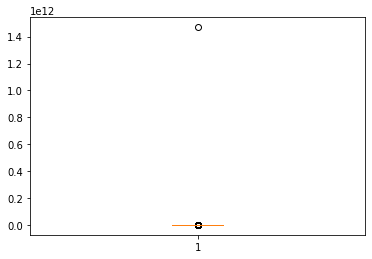

In [6]:
import matplotlib.pyplot as plt
plt.boxplot(df['Estimated Annual Generation'])